In [1]:
#!pip install simpletransformers==0.60.9
!pip install simpletransformers

     |████████████████████████████████| 249 kB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 27.7 MB/s 
     |████████████████████████████████| 4.0 MB 32.6 MB/s 
     |████████████████████████████████| 1.8 MB 34.3 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 10.1 MB 16.4 MB/s 
     |████████████████████████████████| 1.2 MB 31.7 MB/s 
     |████████████████████████████████| 325 kB 32.2 MB/s 
     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
     |████████████████████████████████| 880 kB 21.5 MB/s 
     |████████████████████████████████| 144 kB 39.2 MB/s 
     |████████████████████████████████| 181 kB 30.4 MB/s 
     |████████████████████████████████| 63 kB 821 kB/s 
     |████████████████████████████████| 212 kB 18.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.0 MB/s 
     |████████████████████████████████| 136 kB 36.8 MB/s 
     |██████████████

In [2]:
import pandas as pd
import sklearn
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn

In [3]:
# For Neural models in Colab:

from google.colab import drive
drive.mount('/content/drive')

!ls drive

Mounted at /content/drive
MyDrive  Shareddrives


In [4]:
data_path = 'drive/MyDrive/olid-training-v1.0.tsv'

In [5]:
train = pd.read_csv(data_path, delimiter='\t', encoding='utf-8')
train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [6]:
train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) # rename columns if necessary
train['target'] = train.label.map({'NOT':0, 'OFF':1}) # convert label to a numerical variable
train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) # drop irrelevant columns
train.head()

#create a copy of the original data to work with 
df = train.copy()
df.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [7]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

df['clean'] = df['text'].apply(lambda x: clean(x))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


**Ahora vamos a cambiar todos los 'clean' por 'text', que es el texto sin preprocessing**

In [8]:
train = pd.DataFrame({'text': df.text, 'labels': df.target})
test = pd.DataFrame({'text': df.text, 'labels': df.target})

In [9]:
train.head()

,text,labels
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [10]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=42, 
                               stratify=train[['labels']])

In [11]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

11916
train: labels
0         7956
1         3960
dtype: int64


,text,labels
12900,@USER I think I would pick that just for the f...,0
10804,@USER Or bite it off. Transition complete,0
11237,@USER For the hol tl to see😭. That’s tht Big D...,1


In [12]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

1324
dev: labels
0         884
1         440
dtype: int64


,text,labels
352,@USER @USER She’s said before that she will al...,0
3729,@USER @USER @USER @USER @USER @USER @USER @USE...,0
12763,@USER @USER Just another Dem tactic. Leftist d...,0


In [13]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
# model_args.labels_list=["negative", "positive", "neutral"] # list of labels
model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)

# Initial args
model_args.num_train_epochs=6
model_args.train_batch_size=64
model_args.learning_rate=1e-5 
model_args.max_seq_length=128 

# Early stopping to combat overfitting
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2 #55555555
model_args.evaluate_during_training_steps=32

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False


# model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
# model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)

# model_args.num_train_epochs=6
# model_args.train_batch_size=32
# model_args.learning_rate=4e-6  
# model_args.max_seq_length=128 

# # Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
# model_args.use_early_stopping=True
# model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
# model_args.early_stopping_metric='eval_loss'
# model_args.early_stopping_metric_minimize=True 
# model_args.early_stopping_patience=2 
# model_args.evaluate_during_training_steps=34 # how often you want to run validation in terms of training steps (or batches)

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False

In [14]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args=model_args, use_cuda=True) 

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [15]:
_, history = model.train_model(train, eval_df=dev, f1=sklearn.metrics.f1_score)

  0%|          | 0/11916 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

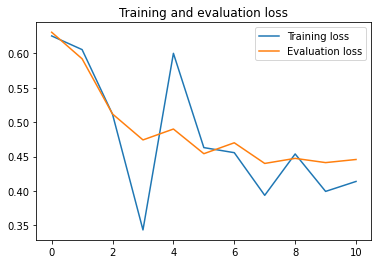

In [16]:
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend();

In [17]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

{'auprc': 0.7331613122683053,
 'auroc': 0.8566137906211435,
 'eval_loss': 0.4457666557955455,
 'fn': 134,
 'fp': 134,
 'mcc': 0.5438708350473056,
 'tn': 750,
 'tp': 306}

In [18]:
predicted, probabilities = model.predict(dev.text.to_list())
dev['predicted'] = predicted

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

In [19]:
test.head()

,text,labels
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [24]:
F1 = f1_score(dev.labels, dev.predicted, average='macro')
F1

0.7719354175236528

In [25]:
dev.head()

,text,labels,predicted
352,@USER @USER She’s said before that she will al...,0,0
3729,@USER @USER @USER @USER @USER @USER @USER @USE...,0,0
12763,@USER @USER Just another Dem tactic. Leftist d...,0,0
9397,@USER @USER @USER Funny how well meaning left ...,0,1
11968,@USER @USER Well it seems like there was some ...,0,0


In [41]:
data_path1 = '/content/drive/MyDrive/data test/test_IN.csv'

In [42]:
test_IN = pd.read_csv(data_path1, delimiter=',', encoding='utf-8')
test_IN.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [43]:
test_IN.shape

(860, 2)

In [44]:
predicted, probabilities = model.predict(test_IN.tweet.to_list())
test_IN['label'] = predicted

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

In [49]:
test_IN.head()

,id,tweet,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1
1,27014,"#ConstitutionDay is revered by Conservatives, ...",0
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0
3,13876,#Watching #Boomer getting the news that she is...,0
4,60133,#NoPasaran: Unity demo to oppose the far-right...,0


In [46]:
test_IN_neural = test_IN[['id', 'label']]
test_IN_neural['label'] = test_IN_neural.label.map({0:'NOT', 1:'OFF'})
test_IN_neural.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label
0,15923,OFF
1,27014,NOT
2,30530,NOT
3,13876,NOT
4,60133,NOT


In [50]:
test_IN_neural.shape

(860, 2)

In [51]:
test_IN_neural.label.value_counts()

NOT    649
OFF    211
Name: label, dtype: int64

In [52]:
test_IN_neural.to_csv('./drive/My Drive/test_IN_neural.csv', index=False)

In [53]:
data_path2 = '/content/drive/MyDrive/data test/test_OUT1.csv'

In [54]:
test_OUT1 = pd.read_csv(data_path2, delimiter=',', encoding='utf-8')
test_OUT1.head()

,id,tweet
0,37,Maybe it could have something to do with the r...
1,127,"Weirdly enough, i think about this fairly freq..."
2,143,Your idea (while posing a real problem with et...
3,146,>it will encourage a part of the people you ba...
4,186,If something like this could make someone supp...


In [55]:
predicted, probabilities = model.predict(test_OUT1.tweet.to_list())
test_OUT1['label'] = predicted

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [56]:
test_OUT1.head()

,id,tweet,label
0,37,Maybe it could have something to do with the r...,0
1,127,"Weirdly enough, i think about this fairly freq...",1
2,143,Your idea (while posing a real problem with et...,0
3,146,>it will encourage a part of the people you ba...,0
4,186,If something like this could make someone supp...,1


In [57]:
test_OUT1_neural = test_OUT1[['id', 'label']]
test_OUT1_neural['label'] = test_OUT1_neural.label.map({0:'NOT', 1:'OFF'})
test_OUT1_neural.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label
0,37,NOT
1,127,OFF
2,143,NOT
3,146,NOT
4,186,OFF


In [58]:
print(test_OUT1_neural.shape)
print(test_OUT1_neural.label.value_counts())

(1207, 2)
NOT    864
OFF    343
Name: label, dtype: int64


In [59]:
test_OUT1_neural.to_csv('./drive/My Drive/test_OUT1_neural.csv', index=False)

In [60]:
data_path3 = '/content/drive/MyDrive/data test/test_OUT2.csv'

In [61]:
test_OUT2 = pd.read_csv(data_path3, delimiter=',', encoding='utf-8')
test_OUT2.head()

,id,tweet
0,0072b9c3697ab8cc,== Argh == \r\n\r\n Some random idiot deleted ...
1,0081b14d79f54b31,(we hate america and we are going to bomb the ...
2,008eb47c4684d190,""" \r\n\r\n So, on the tenth anniversary of 9/1..."
3,010c2a979fab2e3f,casualt i fucked your mum and i liked it !!ies
4,01680b05bde74236,"""Welcome! \r\n\r\n Hello, , and welcome to Wik..."


In [62]:
predicted, probabilities = model.predict(test_OUT2.tweet.to_list())
test_OUT2['label'] = predicted

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
test_OUT2.head()

In [63]:
test_OUT2_neural = test_OUT2[['id', 'label']]
test_OUT2_neural['label'] = test_OUT2_neural.label.map({0:'NOT', 1:'OFF'})
test_OUT2_neural.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label
0,0072b9c3697ab8cc,OFF
1,0081b14d79f54b31,OFF
2,008eb47c4684d190,OFF
3,010c2a979fab2e3f,OFF
4,01680b05bde74236,NOT


In [64]:
print(test_OUT2_neural.shape)
print(test_OUT2_neural.label.value_counts())

(1200, 2)
NOT    615
OFF    585
Name: label, dtype: int64


In [65]:
test_OUT2_neural.to_csv('./drive/My Drive/test_OUT2_neural.csv', index=False)

In [66]:
data_path4 = '/content/drive/MyDrive/data test/test_TEXTGAIN.csv'

In [67]:
test_TEXTGAIN = pd.read_csv(data_path4, delimiter=',', encoding='utf-8')
test_TEXTGAIN.head()

,id,tweet
0,0,"a few American personality camels, well adjust..."
1,1,@juniormufasa_ how come lukaku flop @ man uu ...
2,2,LUKAKU IS SUCH A NIGGER I HATE THIS APE
3,3,I beg you lot keep that porch monkey coon Shau...
4,4,TRY NOT TO GET HIGH AS THE MONKEY !!! ❌\r\n\r\...


In [68]:
test_TEXTGAIN.shape

(1276, 2)

In [69]:
predicted, probabilities = model.predict(test_TEXTGAIN.tweet.to_list())
test_TEXTGAIN['label'] = predicted

  0%|          | 0/1276 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [70]:
test_TEXTGAIN_neural = test_TEXTGAIN[['id', 'label']]
test_TEXTGAIN_neural['label'] = test_TEXTGAIN_neural.label.map({0:'NOT', 1:'OFF'})
test_TEXTGAIN_neural.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label
0,0,NOT
1,1,OFF
2,2,NOT
3,3,OFF
4,4,NOT


In [71]:
print(test_TEXTGAIN_neural.shape)
print(test_TEXTGAIN_neural.label.value_counts())

(1276, 2)
NOT    748
OFF    528
Name: label, dtype: int64


In [72]:
test_TEXTGAIN_neural.to_csv('./drive/My Drive/test_TEXTGAIN_neural.csv', index=False)